In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Image

In [2]:
%matplotlib inline

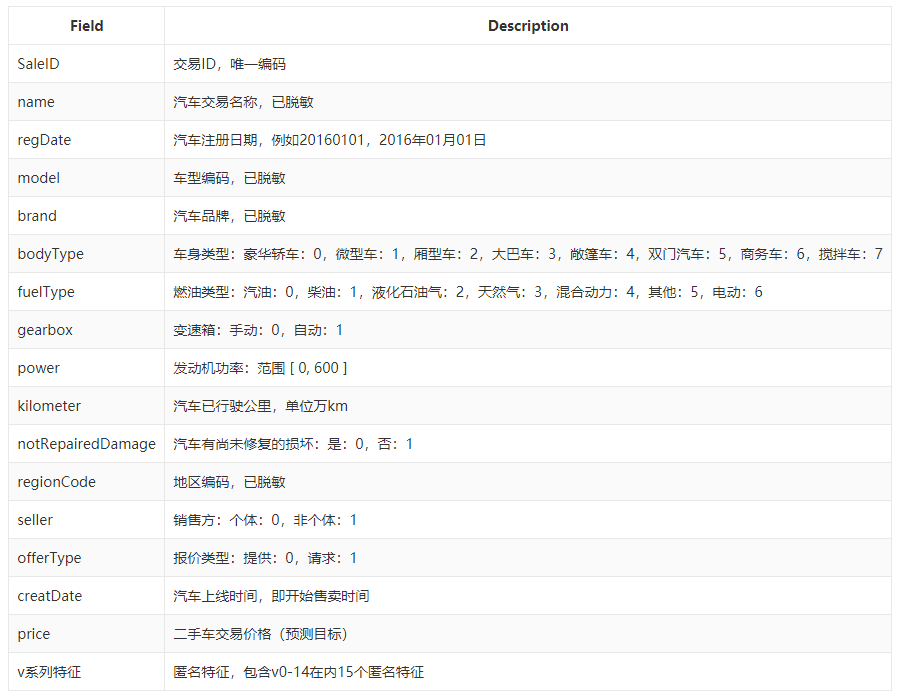

In [3]:
Image('1584102211.png')

## 读取数据

In [4]:
train = pd.read_csv('data/used_car_train_20200313.csv', sep=' ')
train.head(2)

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522


In [5]:
test = pd.read_csv('data/used_car_testA_20200313.csv', sep=' ')
test.head(2)

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,150000,66932,20111212,222.0,4,5.0,1.0,1.0,313,15.0,...,0.264405,0.1218,0.070899,0.106558,0.078867,-7.050969,-0.854626,4.800151,0.620011,-3.664654
1,150001,174960,19990211,19.0,21,0.0,0.0,0.0,75,12.5,...,0.261745,0.0000,0.096733,0.013705,0.052383,3.679418,-0.729039,-3.796107,-1.541230,-0.757055


In [6]:
# 看下数据集样本数
train.shape, test.shape

((150000, 31), (50000, 30))

## 探索性数据分析

### 缺失值检查

In [7]:
# 求空值数量
train.isnull().sum().sort_values(ascending=False).head()

fuelType    8680
gearbox     5981
bodyType    4506
model          1
v_14           0
dtype: int64

### 数据分布

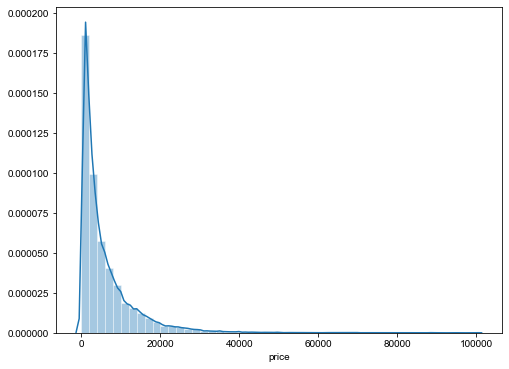

In [8]:
# 目标值分布，右偏分布
fig, ax = plt.subplots(figsize=(8, 6))
sns.set_style("white")
sns.distplot(train['price'])

In [9]:
# 查看分类特征的类别数量
for i in ['name', 'model', 'brand', 'regionCode']:
    print(i, train[i].nunique())

name 99662
model 248
brand 40
regionCode 7905


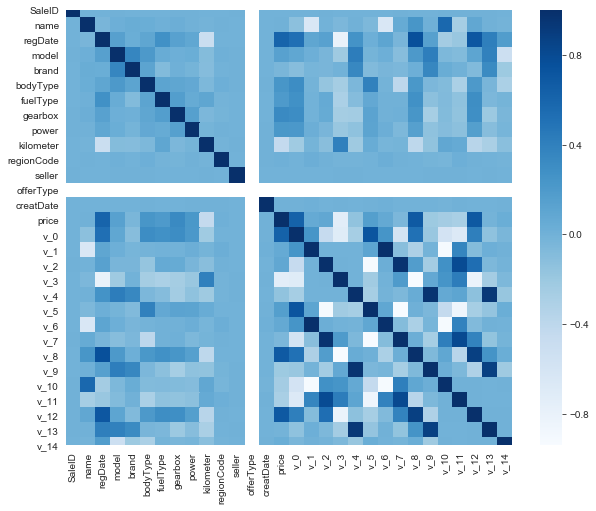

In [10]:
# 查看特征相关系数
corr = train.corr()
plt.subplots(figsize=(10, 8))
sns.heatmap(corr, cmap="Blues")

## 特征工程

### 处理倾斜特征

In [11]:
from scipy.stats import norm

In [12]:
# 目标值做log处理
train['price'] = np.log1p(train['price'])

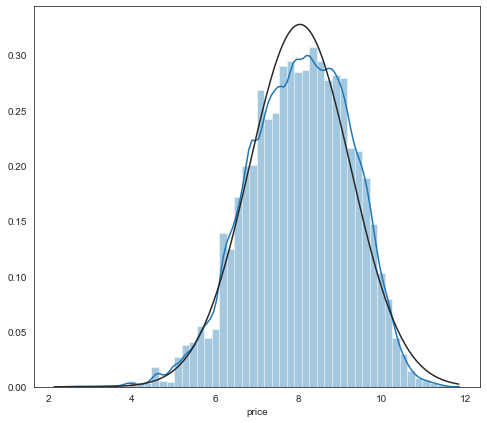

In [14]:
# 查看转化后的分布，有点正态的感觉了
fig, ax = plt.subplots(figsize=(8, 7))
sns.distplot(train['price'], fit=norm)

### 移除异常值

In [15]:
# 可以根据计算结果或者其他特征进行移除
train.drop(train[train['price'] < 4].index, inplace=True)

In [16]:
# 整合训练集测试集以便后续特征工程
train_labels = train['price'].reset_index(drop=True)
train_features = train.drop(['price'], axis=1)
test_features = test
all_features = pd.concat([train_features, test_features]).reset_index(drop=True)

### 填充缺失值

In [24]:
# 根据最常出现填充，都是零，也可以根据其他来填充，不是瞎填的。。
def fill_missing(df):
    df['fuelType'] = df['fuelType'].fillna(0)
    df['gearbox'] = df['gearbox'].fillna(0)
    df['bodyType'] = df['bodyType'].fillna(0)
    df['model'] = df['model'].fillna(0)
    return df

In [25]:
all_features = fill_missing(all_features)

In [26]:
all_features.isnull().sum().head()

SaleID     0
name       0
regDate    0
model      0
brand      0
dtype: int64

### 数据类型转换

In [27]:
# 处理完
def data_astype(df):
    # string
    df['SaleID'] = df['SaleID'].astype(int).astype(str)
    df['name'] = df['name'].astype(int).astype(str)
    df['model'] = df['model'].astype(str)
    df['brand'] = df['brand'].astype(str)
    df['bodyType'] = df['bodyType'].astype(str)
    df['fuelType'] = df['fuelType'].astype(str)
    df['gearbox'] = df['gearbox'].astype(str)
    df['notRepairedDamage'] = df['notRepairedDamage'].astype(str)
    df['regionCode'] = df['regionCode'].astype(int).astype(str)
    df['seller'] = df['seller'].astype(int).astype(str)
    df['offerType'] = df['offerType'].astype(int).astype(str)
    df['regDate'] = df['regDate'].astype(str)
    df['creatDate'] = df['creatDate'].astype(str)
    
    # date
    df['creatDate'] = pd.to_datetime(df['creatDate'])
    return df

In [28]:
all_features = data_astype(all_features)

### 编码分类变量

In [29]:
# 先删除掉一些不要的特征
all_features = all_features.drop(['SaleID', 'name', 'regDate', 'model', 'seller',
                                  'offerType', 'creatDate', 'regionCode'], axis=1)

In [30]:
all_features = pd.get_dummies(all_features).reset_index(drop=True)
all_features.shape

(199766, 77)

### 重新创建训练集和测试集

In [31]:
X = all_features.iloc[:len(train_labels), :]
X_test = all_features.iloc[len(train_labels):, :]
X.shape, train_labels.shape, X_test.shape

((149766, 77), (149766,), (50000, 77))

## 训练模型

In [32]:
from sklearn.linear_model import Ridge, RidgeCV

In [33]:
from sklearn.model_selection import KFold, cross_val_score

### 设置交叉验证

In [34]:
# K折交叉验证
kf = KFold(n_splits=5, random_state=15, shuffle=True)

In [51]:
# 定义评测指标
def cv_mae(model, X):
    mae = -cross_val_score(model, X, train_labels, scoring='neg_mean_absolute_error')
    return mae

### 定义模型

In [37]:
ridge_alphas = [0.1, 1, 3, 5, 10]
ridge = RidgeCV(alphas=ridge_alphas, cv=kf)

### 训练模型

In [39]:
# 查看交叉验证分数
score = cv_mae(ridge, X)

In [40]:
score

array([0.19779685, 0.19911369, 0.19930195, 0.19632974, 0.20047872])

In [41]:
score.mean()

0.19860419017501124

In [46]:
ridge.fit(X, train_labels)

RidgeCV(alphas=array([ 0.1,  1. ,  3. ,  5. , 10. ]),
        cv=KFold(n_splits=5, random_state=15, shuffle=True), fit_intercept=True,
        gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [50]:
# 查看R的平方
ridge.score(X, train_labels)

0.9368702755273388

### 模型预测

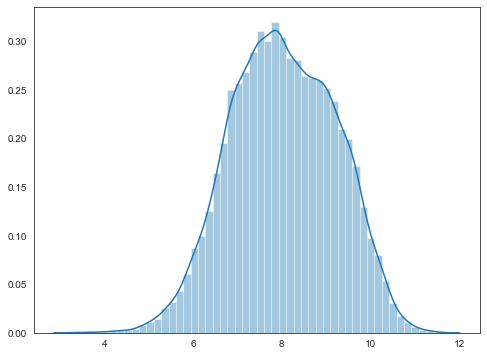

In [54]:
# 查看预测结果
fig, ax = plt.subplots(figsize=(8, 6))
sns.distplot(ridge.predict(X_test))

In [52]:
# 预测结果
submission = test[['SaleID']].copy()
submission['price'] = np.expm1(ridge.predict(X_test))
submission.shape

(50000, 2)

In [53]:
submission.to_csv('submission.csv', index=False)